In [2]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  
import pandas as pd
import scipy.sparse as sps

from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [3]:
def load_URM(file_path):

    data = pd.read_csv(file_path)


    user_list = data['row'].tolist()
    item_list = data['col'].tolist()
    rating_list = data['data'].tolist()

    return sps.coo_matrix((rating_list, (user_list, item_list))).tocsr()

In [4]:
URM_all = load_URM('input/data_train.csv')


In [5]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13637 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions


In [9]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
import numpy as np

class ItemKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores



In [10]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 18059 (100.0%), 1457.69 column/sec. Elapsed time 12.39 sec


In [11]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1494.30 column/sec. Elapsed time 9.13 sec
EvaluatorHoldout: Processed 13636 (100.0%) in 3.53 sec. Users per second: 3867
UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1489.22 column/sec. Elapsed time 9.17 sec
EvaluatorHoldout: Processed 13636 (100.0%) in 4.57 sec. Users per second: 2982
UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1465.21 column/sec. Elapsed time 9.32 sec
EvaluatorHoldout: Processed 13636 (100.0%) in 5.48 sec. Users per second: 2490
UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Py

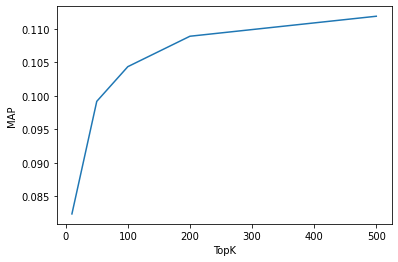

In [12]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [13]:
x_tick = range(1,11)
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1374.00 column/sec. Elapsed time 9.93 sec
EvaluatorHoldout: Processed 13636 (100.0%) in 5.64 sec. Users per second: 2416
UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1426.69 column/sec. Elapsed time 9.57 sec
EvaluatorHoldout: Processed 13636 (100.0%) in 5.74 sec. Users per second: 2377
UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1450.05 column/sec. Elapsed time 9.41 sec
EvaluatorHoldout: Processed 13636 (100.0%) in 5.74 sec. Users per second: 2376
UserKNNCFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Py

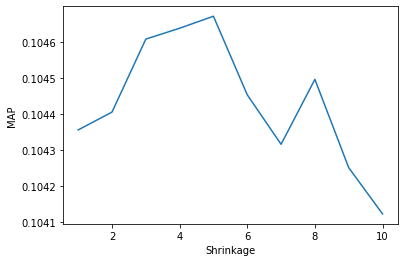

In [14]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [18]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=5.0, topK=700)

Similarity column 18059 (100.0%), 1302.66 column/sec. Elapsed time 13.86 sec


In [21]:
import pandas as pd
from tqdm import tqdm
submission = pd.DataFrame(columns=['user_id', 'item_list'])

for i in tqdm(range(13650), desc="getting recommendations"):
    item_list = recommender.recommend(i, 10)
    submission.loc[i] = [i, ' '.join([str(i) for i in item_list])]

submission

getting recommendations: 100%|██████████| 13650/13650 [02:57<00:00, 77.04it/s]


,user_id,item_list
0,0,13229 3899 3473 2665 8635 9131 15119 8207 1736...
1,1,3473 13914 15778 7295 16365 14400 14181 2665 1...
2,2,3899 17330 6214 8635 5273 5925 13134 10865 617...
3,3,8194 14358 3899 17788 6975 17330 2665 13229 10...
4,4,3473 6177 13134 14358 17330 2665 13229 16365 3...
...,...,...
13645,13645,8635 6177 10865 1259 13914 13134 2665 9441 194...
13646,13646,3473 8635 16846 2665 14181 13914 13134 5273 12...
13647,13647,8635 16365 17330 16846 5273 2665 10865 14181 1...
13648,13648,3899 6177 8635 6214 17330 14358 15119 14181 13...


In [25]:
from datetime import datetime
submission.to_csv(f'output/cf_{str(datetime.now())}.csv', index=False)